# Problem Formulation
when people prepare to post a new listing on airbnb is, how much should one ask for? Of course the most intuitive way is to check how other similar postings price their apartment/house. So in this assignment, we are going to predict the listing price based on the listing characteristics

# **Why do we use sparse_categorical_crossentropy?**
categorical_crossentropy (cce) produces a one-hot array containing the probable match for each category.

we use sparse_categorical_crossentropy (scce) because it  produces a category index of the most likely matching category 

For example:In the case of cce, the one-hot target may be [0, 1, 0, 0, 0] and the model may predict [.2, .5, .1, .1, .1] (probably right)

In the case of scce, the target index may be [1] and the model may predict: [.5]

# **Recurrent Neural Networks**

In a recurrent neural network we store the output activations from one or more of the layers of the network. Often these are hidden later activations. Then, the next time we feed an input example to the network, we include the previously-stored outputs as additional inputs.

# **why do we use LSTM?**

RNNs suffer from the problem of vanishing gradients. The gradients carry information used in the RNN, and when the gradient becomes too small, the parameter updates become insignificant. This makes the learning of long data sequences difficult. Instead, we use a better variation of RNNs: Long Short Term Networks(LSTM).



# The input and output
The input contains (summary	and image)                       
The output represents as two output (type and price)

# What data mining function is required?
predict function is the process of identifying the unavailable data for new observation based on the previous data and classification function to identify class label of new observation to which it belongs.

# why do we use dropout /SpatialDropout1D?
- Dropout prevents overfitting ,Because the outputs of a layer under dropout are randomly subsampled, it has the effect of reducing the capacity or thinning the network during training.
- SpatialDropout1D drops entire 1D feature maps instead of individual elements. If adjacent frames within feature maps are strongly correlated (as is normally the case in early convolution layers) then regular dropout will not regularize the activations and will otherwise just result in an effective learning rate decrease. In this case, SpatialDropout1D will help promote independence between feature maps and should be used instead.

# why do we use Bidirectional?
Bidirectional recurrent neural networks (BRNN) connect two hidden layers of opposite directions to the same output. With this form of generative deep learning, the output layer can get information from past (backwards) and future (forward) states simultaneously.
-Bidirectional LSTMs are an extension of traditional LSTMs that can improve model performance on sequence classification problems

# What is the impact?
performance in each trail dependence on text model and image model .
The model uses Adam for tuning weights, sparse categorical cross-entropy loss, and sparse categorical accuracy for evaluation for both objectives. The loss with respect to each task is weighted equally when computing the overall loss of the model. We use the sparse version of these metrics as our categorical labels are integers instead of being one-hot encoded.
The model is trained for 20 epochs with a batch size of 16 and a hold-out validation set of 20%. Early stopping is used to make training more efficient and to also prevent overfitting. Once training stops, the model is used to make predictions on the test set format them for submission. The submission only contains the price categories for each listing as per the assignment objective, despite the multi-objective approach.

# Ideal solution
dependence in changes in each model but i see the model with embidding and averaged only gives accuracy= 0.68

# importing libraries

In [1]:
import os
import pandas as pd
from tqdm.notebook import tqdm
from PIL import Image
import pandas as pd
import os
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from __future__ import absolute_import, division, print_function, unicode_literals
import collections
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D,LSTM,SpatialDropout1D,Dropout,Bidirectional,Embedding,RNN,SimpleRNN
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential


# read data


In [2]:
data_train=pd.read_csv('train_xy.csv')
data_test=pd.read_csv('test_x.csv')
data_train

,summary,image,type,price
0,"Spacious, sunny and cozy modern apartment in t...",img_train/0.jpg,Apartment,1
1,Located in one of the most vibrant and accessi...,img_train/1.jpg,Apartment,0
2,Logement coquet et douillet à 10 minutes du ce...,img_train/2.jpg,Apartment,1
3,"Beautiful and spacious (1076 sc ft, / 100 mc) ...",img_train/3.jpg,Apartment,1
4,Très grand appartement ''rustique'' et très ag...,img_train/4.jpg,Apartment,0
...,...,...,...,...
7622,"Un grand logement 4 et 1/2, tout inclut, bien ...",img_train/7626.jpg,Apartment,0
7623,Magnificent condo directly on the river. You w...,img_train/7627.jpg,Apartment,2
7624,This apartment is perfect for anyone visiting ...,img_train/7628.jpg,Apartment,1
7625,"It is a cozy ,clean ,and comfortable apartment...",img_train/7629.jpg,Apartment,0


# Data exploration


In [3]:
data_train.info() #display inforamtion of data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7627 entries, 0 to 7626
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   summary  7326 non-null   object
 1   image    7627 non-null   object
 2   type     7627 non-null   object
 3   price    7627 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 238.5+ KB


In [4]:
#check null value for every feature
print(data_train.isnull().sum())
print(data_test.isnull().sum())

summary    301
image        0
type         0
price        0
dtype: int64
id         0
summary    0
image      0
dtype: int64


In [5]:
data_train.dropna(inplace=True) # drop null values

In [6]:
#convert type into category type
data_train['type'] = data_train.type.astype('category').cat.codes
#display unique values on type column
len_type = len(data_train.type.unique())
#display unique values on price column
len_price = len(data_train.price.unique())


In [7]:
#build function to read image and resize it and convert colours into black and white
def load_image(file):
    try:
        image = Image.open(
            file
        ).convert('LA').resize((64, 64))
        arr = np.array(image)
    except:
        arr = np.zeros((64, 64, 2))
    return arr


# loading images:
#tqmd to display the progress of loading images
x_train_image = np.array([load_image(i) for i in tqdm(data_train.image)])

# loading summary: (force convert some of the non-string cell to string)
x_train_text = data_train.summary.astype('str')

# get type 
y_train_type = data_train.type

# get price
y_train_price = data_train.price

# why we use Tokenizer?
The Tokenizer class of Keras is used for vectorizing a text corpus. For this either, each text input is converted into integer sequence or a vector that has a coefficient for each token in the form of binary values

In [8]:
vocab_size = 40000
max_len = 200
tokenizer=Tokenizer(num_words=vocab_size)
# build vocabulary from training set
tokenizer.fit_on_texts(x_train_text)
def _preprocess(list_of_text):
    return pad_sequences(
        tokenizer.texts_to_sequences(list_of_text),
        maxlen=max_len,
        padding='post', #Using `post` for padding will add the zeros at the end of the sequences. 
    )
    

# padding is done inside: 
x_train_text_id = _preprocess(x_train_text)
x_train_text_id.shape

(7326, 200)

In [9]:
# loading images:
x_test_image = np.array([load_image(i) for i in tqdm(data_test.image)])

# loading overview: (force convert some of the non-string cell to string)
x_test_text = _preprocess(data_test.summary.astype('str'))

## make function to plot the result to see the overfitting

In [10]:
def results_viz(history):

  # generate a figure containing 3 plots displayed horizontally
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))
  fig.suptitle('Model Results')
  
  # first we display the training price accuracy vs. the validation price accuracy
  ax1.plot(history.history['price_sparse_categorical_accuracy'])
  ax1.plot(history.history['val_price_sparse_categorical_accuracy'])
  ax1.set_title('price accuracy')
  ax1.set_ylabel('accuracy')
  ax1.set_xlabel('epoch')
  ax1.legend(['train_price', 'validation_price'], loc='upper left')

  # same with the other specified accuracy metric, type accuracy
  ax2.plot(history.history['type_sparse_categorical_accuracy'])
  ax2.plot(history.history['val_type_sparse_categorical_accuracy'])
  ax2.set_title('type accuracy')
  ax2.set_ylabel('accuracy')
  ax2.set_xlabel('epoch')
  ax2.legend(['train_type', 'validation_type'], loc='upper left')

  # on the last axis, we plot the training loss against the validation loss (w.r.t. price and type combined)
  ax3.plot(history.history['loss'])
  ax3.plot(history.history['val_loss'])
  ax3.set_title('model loss')
  ax3.set_ylabel('loss')
  ax3.set_xlabel('epoch')
  ax3.legend(['train', 'validation'], loc='upper left')

  plt.show() # display the figure

# Trial 1 RNN
A Recurrent Neural Network is a type of neural network that contains loops, allowing information to be stored within the network, uses their reasoning from previous experiences to inform the upcoming events. 
### SpatialDropout1D
performs the same function as Dropout, however, it drops entire 1D feature maps instead of individual elements.
### max pooling layer
is a pooling operation that calculates the maximum, or largest, value in each patch of each feature map.
### Flatten layer
To bring all levels of a multi-layered image down to one dimension.

In [11]:
#define input text
input_text=keras.Input(batch_shape=(None,max_len))
#define input image
input_image=keras.Input(batch_shape=(None,64,64,2))
# text part
# simple average of embedding.
embedded = keras.layers.Embedding(tokenizer.num_words, 200,)(input_text)
out1=SpatialDropout1D(0.3)(embedded)
out=SimpleRNN(256,dropout=0.2)(out1)
# image part 
# simple conv2d contains set of filters with size of filter
cov = Conv2D(128, (16, 16))(input_image)
pl = MaxPool2D((12, 12))(cov)
flattened = Flatten()(pl)
# fusion - combinig both
fused = tf.concat([out, flattened], axis=-1)

# multi-task learning (each is a multi-class classification)
# one dense layer for each task
p_type = Dense(len_type, activation='softmax', name='type')(fused)
p_price = Dense(len_price, activation='softmax', name='price')(fused)


# define model input/output using keys.
model = keras.Model(
    inputs={
        'summary': input_text,
        'image': input_image
    },
    outputs={
        'type': p_type,
        'price': p_price,
    },
)
# compile model with optimizer, loss values for each task, loss 
# weights for each task.
model.compile(
    optimizer=Adam(),
    loss={
        'type': 'sparse_categorical_crossentropy',
        'price': 'sparse_categorical_crossentropy',
    },
    loss_weights={
        'type': 0.5,
        'price': 0.5,       
    },
    metrics={
        'type': ['SparseCategoricalAccuracy'],
        'price': ['SparseCategoricalAccuracy'],
    },
)


model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 embedding (Embedding)          (None, 200, 200)     8000000     ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 49, 49, 128)  65664       ['input_2[0][0]']                
                                                                                              

In [18]:
history = model.fit(
    x={
        'summary': x_train_text_id,
        'image': x_train_image
    },
    y={
        'type': y_train_type,
        'price': y_train_price,
    },
    epochs=20,
    batch_size=16,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_price_loss', patience=5, )
    ],
    verbose=1
)

Epoch 1/20
382/382 [==============================] - 52s 135ms/step - loss: 0.9819 - price_loss: 0.8623 - type_loss: 1.1015 - price_sparse_categorical_accuracy: 0.6079 - type_sparse_categorical_accuracy: 0.7461 - val_loss: 0.9127 - val_price_loss: 0.8487 - val_type_loss: 0.9766 - val_price_sparse_categorical_accuracy: 0.6252 - val_type_sparse_categorical_accuracy: 0.7647
Epoch 2/20
382/382 [==============================] - 52s 137ms/step - loss: 0.9499 - price_loss: 0.8533 - type_loss: 1.0466 - price_sparse_categorical_accuracy: 0.6189 - type_sparse_categorical_accuracy: 0.7528 - val_loss: 0.9146 - val_price_loss: 0.8433 - val_type_loss: 0.9859 - val_price_sparse_categorical_accuracy: 0.6252 - val_type_sparse_categorical_accuracy: 0.7647
Epoch 3/20
382/382 [==============================] - 51s 134ms/step - loss: 0.9536 - price_loss: 0.8621 - type_loss: 1.0451 - price_sparse_categorical_accuracy: 0.6063 - type_sparse_categorical_accuracy: 0.7535 - val_loss: 0.9341 - val_price_loss: 0

In [19]:
y_predict = model.predict(
    {
        'summary': x_test_text,
        'image': x_test_image
    }
)


# probabilities
price_predicted = y_predict['price']
type_predicted=y_predict['type']
print(price_predicted)
print(type_predicted)
# categories
price_category_predicted = np.argmax(price_predicted, axis=1)
print(price_category_predicted)


[[0.6340829  0.31203377 0.0538833 ]
 [0.6340829  0.3120338  0.0538833 ]
 [0.5394643  0.32986432 0.13067137]
 ...
 [0.59261346 0.36231926 0.04506723]
 [0.5926136  0.36231926 0.04506722]
 [0.5394643  0.32986432 0.13067137]]
[[1.4180766e-04 7.2117007e-01 3.7707931e-03 ... 7.0584979e-04
  3.1464662e-02 3.6464969e-04]
 [1.4180766e-04 7.2117007e-01 3.7707931e-03 ... 7.0584944e-04
  3.1464662e-02 3.6464969e-04]
 [5.3227367e-03 7.1588719e-01 1.2214801e-02 ... 3.2086190e-04
  1.9246442e-02 4.7395295e-03]
 ...
 [5.5423443e-04 6.8436277e-01 2.0238476e-02 ... 5.5521395e-04
  2.6240198e-02 1.5180405e-03]
 [5.5423408e-04 6.8436265e-01 2.0238487e-02 ... 5.5521412e-04
  2.6240204e-02 1.5180417e-03]
 [5.3227330e-03 7.1588737e-01 1.2214804e-02 ... 3.2086167e-04
  1.9246439e-02 4.7395281e-03]]
[0 0 0 ... 0 0 0]


In [20]:
d=pd.DataFrame(
    {'id': data_test.id,
     'price': price_category_predicted}
).to_csv('sample_submission3333.csv', index=False)

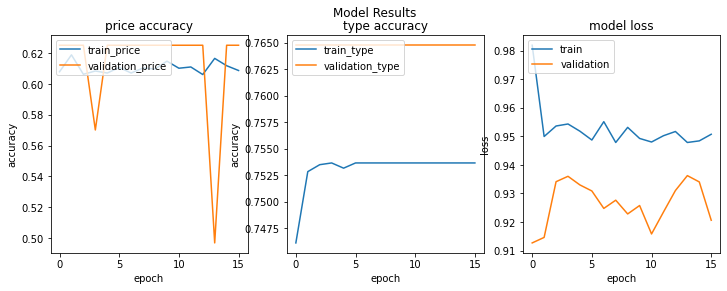

In [21]:
results_viz(history)

### Test accuracy by using RNN in text data = 0.62038 in leaderboard . i will try to improve the performance by calculating reduce_mean  instead of RNN

# Trial 2
with embedding layer and one convolutional layer with max poolong and flatten layers
#### averaged 
reduces input_tensor along the dimensions given in axis by computing the mean of elements across the dimensions in axis

In [22]:
embedded = keras.layers.Embedding(tokenizer.num_words, 200)(input_text)
averaged = tf.reduce_mean(embedded, axis=1)
# image part 
# simple conv2d
cov = Conv2D(64, (16, 16))(input_image)
pl = MaxPool2D((12, 12))(cov)
flattened = Flatten()(pl)
# fusion - combinig both
fused = tf.concat([averaged, flattened], axis=-1)
# multi-task learning (each is a multi-class classification)
# one dense layer for each task
p_type = Dense(len_type, activation='softmax', name='type')(fused)
p_price = Dense(len_price, activation='softmax', name='price')(fused)


# define model input/output using keys.
model = keras.Model(
    inputs={
        'summary': input_text,
        'image': input_image
    },
    outputs={
        'type': p_type,
        'price': p_price,
    },
)
# compile model with optimizer, loss values for each task, loss 
# weights for each task.
model.compile(
    optimizer=Adam(),
    loss={
        'type': 'sparse_categorical_crossentropy',
        'price': 'sparse_categorical_crossentropy',
    },
    loss_weights={
        'type': 0.5,
        'price': 0.5,       
    },
    metrics={
        'type': ['SparseCategoricalAccuracy'],
        'price': ['SparseCategoricalAccuracy'],
    },
)


model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 conv2d_8 (Conv2D)              (None, 49, 49, 64)   32832       ['input_4[0][0]']                
                                                                                                  
 embedding_2 (Embedding)        (None, 200, 200)     8000000     ['input_3[0][0]']                
                                                                                            

In [23]:
history = model.fit(
    x={
        'summary': x_train_text_id,
        'image': x_train_image
    },
    y={
        'type': y_train_type,
        'price': y_train_price,
    },
    epochs=20,
    batch_size=16,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_price_loss', patience=5, )
    ],
    verbose=1
)

Epoch 1/20
382/382 [==============================] - 30s 78ms/step - loss: 1.0024 - price_loss: 0.8493 - type_loss: 1.1555 - price_sparse_categorical_accuracy: 0.6183 - type_sparse_categorical_accuracy: 0.7505 - val_loss: 0.8894 - val_price_loss: 0.8142 - val_type_loss: 0.9646 - val_price_sparse_categorical_accuracy: 0.6252 - val_type_sparse_categorical_accuracy: 0.7647
Epoch 2/20
382/382 [==============================] - 30s 80ms/step - loss: 0.9024 - price_loss: 0.8034 - type_loss: 1.0013 - price_sparse_categorical_accuracy: 0.6284 - type_sparse_categorical_accuracy: 0.7536 - val_loss: 0.8554 - val_price_loss: 0.7717 - val_type_loss: 0.9392 - val_price_sparse_categorical_accuracy: 0.6507 - val_type_sparse_categorical_accuracy: 0.7647
Epoch 3/20
382/382 [==============================] - 30s 78ms/step - loss: 0.8556 - price_loss: 0.7481 - type_loss: 0.9631 - price_sparse_categorical_accuracy: 0.6628 - type_sparse_categorical_accuracy: 0.7536 - val_loss: 0.8256 - val_price_loss: 0.73

In [24]:
y_predict = model.predict(
    {
        'summary': x_test_text,
        'image': x_test_image
    }
)


# probabilities
price_predicted = y_predict['price']
type_predicted=y_predict['type']
print(price_predicted)

# categories
price_category_predicted = np.argmax(price_predicted, axis=1)
print(price_category_predicted)


[[0.7589336  0.1973845  0.04368188]
 [0.9809186  0.01623425 0.00284717]
 [0.952564   0.03420074 0.01323519]
 ...
 [0.76138055 0.21263988 0.02597957]
 [0.9876938  0.00909953 0.00320672]
 [0.770472   0.20534714 0.02418081]]
[0 0 0 ... 0 0 0]


In [25]:
d=pd.DataFrame(
    {'id': data_test.id,
     'price': price_category_predicted}
).to_csv('sample_submission11.csv', index=False)

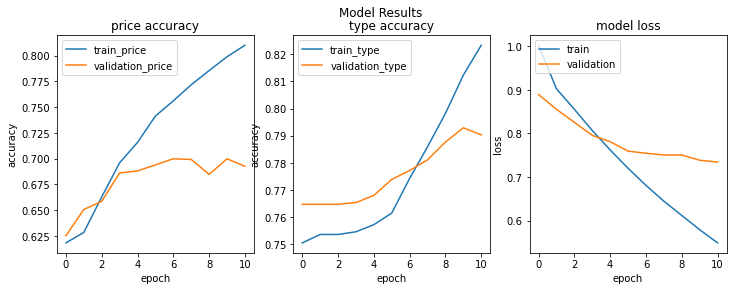

In [26]:
results_viz(history)

### Test accuracy = 0.68 which is more than accuracy in trail 1 
### as we see ,it improves the accuracy

# Trial 3 LSTM

#### i will try to use LSTM layer to prevent vanishing gradients

In [10]:
out=SpatialDropout1D(0.2)(embedded)
out=LSTM(256,dropout=0.2)(out)
# image part 
# simple conv2d
cov = Conv2D(64, (16, 16))(input_image)
# add max pooling layer
pl = MaxPool2D((12, 12))(cov)
#add flatten layer
flattened = Flatten()(pl)

# fusion - combinig both
fused = tf.concat([out, flattened], axis=-1)

# multi-task learning (each is a multi-class classification)
# one dense layer for each task
p_type = Dense(len_type, activation='softmax', name='type')(fused)
p_price = Dense(len_price, activation='softmax', name='price')(fused)


# define model input/output using keys.
model = keras.Model(
    inputs={
        'summary': input_text,
        'image': input_image
    },
    outputs={
        'type': p_type,
        'price': p_price,
    },
)
# compile model with optimizer, loss values for each task, loss 
# weights for each task.
model.compile(
    optimizer=Adam(),
    loss={
        'type': 'sparse_categorical_crossentropy',
        'price': 'sparse_categorical_crossentropy',
    },
    loss_weights={
        'type': 0.5,
        'price': 0.5,       
    },
    metrics={
        'type': ['SparseCategoricalAccuracy'],
        'price': ['SparseCategoricalAccuracy'],
    },
)


model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 200, 200)     8000000     ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 49, 49, 64)   32832       ['input_2[0][0]']                
                                                                                            

In [11]:
history = model.fit(
    x={
        'summary': x_train_text_id,
        'image': x_train_image
    },
    y={
        'type': y_train_type,
        'price': y_train_price,
    },
    epochs=20,
    batch_size=16,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_price_loss', patience=5, )
    ],
    verbose=1
)

Epoch 1/20
382/382 [==============================] - 94s 241ms/step - loss: 0.9596 - price_loss: 0.8524 - type_loss: 1.0667 - price_sparse_categorical_accuracy: 0.6110 - type_sparse_categorical_accuracy: 0.7518 - val_loss: 0.9146 - val_price_loss: 0.8499 - val_type_loss: 0.9793 - val_price_sparse_categorical_accuracy: 0.6252 - val_type_sparse_categorical_accuracy: 0.7647
Epoch 2/20
382/382 [==============================] - 90s 236ms/step - loss: 0.9344 - price_loss: 0.8435 - type_loss: 1.0253 - price_sparse_categorical_accuracy: 0.6201 - type_sparse_categorical_accuracy: 0.7536 - val_loss: 0.9025 - val_price_loss: 0.8313 - val_type_loss: 0.9736 - val_price_sparse_categorical_accuracy: 0.6252 - val_type_sparse_categorical_accuracy: 0.7647
Epoch 3/20
382/382 [==============================] - 94s 247ms/step - loss: 0.9328 - price_loss: 0.8420 - type_loss: 1.0236 - price_sparse_categorical_accuracy: 0.6201 - type_sparse_categorical_accuracy: 0.7536 - val_loss: 0.9134 - val_price_loss: 0

In [12]:
y_predict = model.predict(
    {
        'summary': x_test_text,
        'image': x_test_image
    }
)


# probabilities
price_predicted = y_predict['price']
type_predicted=y_predict['type']
print(price_predicted)
# categories
price_category_predicted = np.argmax(price_predicted, axis=1)
print(price_category_predicted)

[[0.6029982  0.3425658  0.05443592]
 [0.6029982  0.34256583 0.05443592]
 [0.6029982  0.3425658  0.0544359 ]
 ...
 [0.6029982  0.3425658  0.0544359 ]
 [0.6029982  0.3425658  0.05443592]
 [0.6029982  0.3425658  0.0544359 ]]
[0 0 0 ... 0 0 0]


In [13]:
d=pd.DataFrame(
    {'id': data_test.id,
     'price': price_category_predicted}
).to_csv('sample_submissionLSTM.csv', index=False)

### test accuracy is decreased to 0.62038
### i will try to use bidirectional layer 

# **Trial 4 by using two BiDirectional layer**

Bidirectional recurrent neural networks (BRNN) connect two hidden layers of opposite directions to the same output. With this form of generative deep learning, the output layer can get information from past (backwards) and future (forward) states simultaneously

In [27]:
#text part
out=Bidirectional(LSTM(150, return_sequences=True))(embedded) 
out=Bidirectional(LSTM(150))(out)
# image part 
# simple conv2d. you can change it to anything else as needed
cov = Conv2D(64, (16, 16))(input_image)
pl = MaxPool2D((12, 12))(cov)
flattened = Flatten()(pl)

# fusion - combinig both
fused = tf.concat([out, flattened], axis=-1)

# multi-task learning (each is a multi-class classification)
# one dense layer for each task
p_type = Dense(len_type, activation='softmax', name='type')(fused)
p_price = Dense(len_price, activation='softmax', name='price')(fused)


# define model input/output using keys.
model = keras.Model(
    inputs={
        'summary': input_text,
        'image': input_image
    },
    outputs={
        'type': p_type,
        'price': p_price,
    },
)
# compile model with optimizer, loss values for each task, loss 
# weights for each task.
model.compile(
    optimizer=Adam(learning_rate=0.001),
    
    loss={
        'type': 'sparse_categorical_crossentropy',
        'price': 'sparse_categorical_crossentropy',
    },
    metrics={
        'type': ['SparseCategoricalAccuracy'],
        'price': ['SparseCategoricalAccuracy'],
    },
)


model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 200, 200)     8000000     ['input_3[0][0]']                
                                                                                                  
 conv2d_9 (Conv2D)              (None, 49, 49, 64)   32832       ['input_4[0][0]']                
                                                                                            

In [28]:
history = model.fit(
    x={
        'summary': x_train_text_id,
        'image': x_train_image
    },
    y={
        'type': y_train_type,
        'price': y_train_price,
    },
    epochs=20,
    batch_size=16,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_price_loss', patience=5, )
    ],
    verbose=1
)

Epoch 1/20
382/382 [==============================] - 143s 364ms/step - loss: 1.3531 - price_loss: 0.5894 - type_loss: 0.7636 - price_sparse_categorical_accuracy: 0.7617 - type_sparse_categorical_accuracy: 0.7981 - val_loss: 1.7406 - val_price_loss: 0.8904 - val_type_loss: 0.8501 - val_price_sparse_categorical_accuracy: 0.6507 - val_type_sparse_categorical_accuracy: 0.7674
Epoch 2/20
382/382 [==============================] - 141s 369ms/step - loss: 1.0490 - price_loss: 0.4806 - type_loss: 0.5684 - price_sparse_categorical_accuracy: 0.8120 - type_sparse_categorical_accuracy: 0.8446 - val_loss: 1.6520 - val_price_loss: 0.7799 - val_type_loss: 0.8722 - val_price_sparse_categorical_accuracy: 0.6828 - val_type_sparse_categorical_accuracy: 0.7805
Epoch 3/20
382/382 [==============================] - 136s 357ms/step - loss: 0.9068 - price_loss: 0.4312 - type_loss: 0.4756 - price_sparse_categorical_accuracy: 0.8302 - type_sparse_categorical_accuracy: 0.8636 - val_loss: 1.7661 - val_price_loss

In [29]:
y_predict = model.predict(
    {
        'summary': x_test_text,
        'image': x_test_image
    }
)


# probabilities
price_predicted = y_predict['price']
type_predicted=y_predict['type']

print(price_predicted)

# categories
price_category_predicted = np.argmax(price_predicted, axis=1)
print(price_category_predicted)
d=pd.DataFrame(
    {'id': data_test.id,
     'price': price_category_predicted}
).to_csv('sample_submissionbid.csv', index=False)

[[4.84534763e-02 9.36074555e-01 1.54719064e-02]
 [9.98830736e-01 1.01714861e-03 1.52229710e-04]
 [9.96605039e-01 2.82590138e-03 5.69019583e-04]
 ...
 [6.16628945e-01 3.63808930e-01 1.95620600e-02]
 [9.99174058e-01 3.60785692e-04 4.65090183e-04]
 [8.67259443e-01 1.01598516e-01 3.11420579e-02]]
[1 0 0 ... 0 0 0]


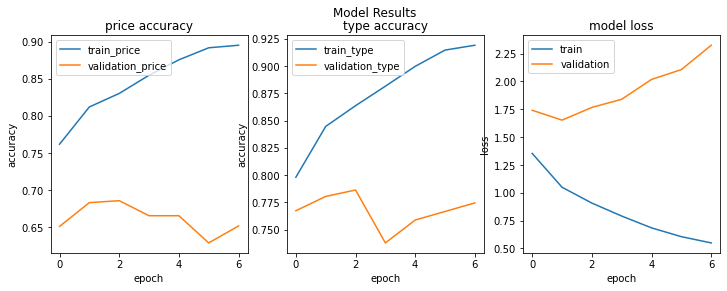

In [30]:
results_viz(history)

### test accuracy is incresed to 0.65027 
### i see overfitting when the training loss decreases but the validation loss increases.

# **Trial 5**
add Dropout layer in image part to prevent overfitting with one Bidirectional

In [31]:
out=Bidirectional(LSTM(256))(embedded)
# image part
conv=Conv2D(64,(16,16))(input_image)
pool=MaxPool2D(12,12)(conv)
drop=Dropout(0.3)(pool) #add dropout layer with 30%
flatten=Flatten()(drop)
#compine two parts for multi-modality
fused=tf.concat([out, flatten], axis=-1)
#for multi-task 
#build one dense layer for each
p_type = Dense(len_type, activation='softmax', name='type')(fused)
p_price = Dense(len_price, activation='softmax', name='price')(fused)
model=keras.Model(
    inputs={
        'summary': input_text,
        'image': input_image
    },
    outputs={
        'type': p_type,
        'price': p_price,
    },
)
# compile model
model.compile(optimizer=Adam(learning_rate=0.01),
    loss={
        'type': 'sparse_categorical_crossentropy',
        'price': 'sparse_categorical_crossentropy',
    },
    metrics={
        'type': ['SparseCategoricalAccuracy'],
        'price': ['SparseCategoricalAccuracy'],
    },
)


model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 conv2d_10 (Conv2D)             (None, 49, 49, 64)   32832       ['input_4[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 max_pooling2d_10 (MaxPooling2D  (None, 4, 4, 64)    0           ['conv2d_10[0][0]']              
 )                                                                                          

In [32]:
history = model.fit(
    x={
        'summary': x_train_text_id,
        'image': x_train_image
    },
    y={
        'type': y_train_type,
        'price': y_train_price,
    },
    epochs=20,
    batch_size=16,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_price_loss', patience=5, )
    ],
    verbose=1
)

Epoch 1/20
382/382 [==============================] - 160s 413ms/step - loss: 1.5313 - price_loss: 0.7082 - type_loss: 0.8231 - price_sparse_categorical_accuracy: 0.6878 - type_sparse_categorical_accuracy: 0.7722 - val_loss: 1.6870 - val_price_loss: 0.7954 - val_type_loss: 0.8916 - val_price_sparse_categorical_accuracy: 0.6429 - val_type_sparse_categorical_accuracy: 0.7582
Epoch 2/20
382/382 [==============================] - 158s 413ms/step - loss: 1.1830 - price_loss: 0.5688 - type_loss: 0.6142 - price_sparse_categorical_accuracy: 0.7725 - type_sparse_categorical_accuracy: 0.8227 - val_loss: 1.9103 - val_price_loss: 0.9072 - val_type_loss: 1.0031 - val_price_sparse_categorical_accuracy: 0.6461 - val_type_sparse_categorical_accuracy: 0.7398
Epoch 3/20
382/382 [==============================] - 158s 413ms/step - loss: 1.0945 - price_loss: 0.5213 - type_loss: 0.5733 - price_sparse_categorical_accuracy: 0.7954 - type_sparse_categorical_accuracy: 0.8317 - val_loss: 2.0211 - val_price_loss

In [33]:
y_predict = model.predict(
    {
        'summary': x_test_text,
        'image': x_test_image
    }
)


# probabilities
price_predicted = y_predict['price']
type_predicted=y_predict['type']
print(price_predicted)

# categories
price_category_predicted = np.argmax(price_predicted, axis=1)
type_category_predicted = np.argmax(type_predicted, axis=1)
print(price_category_predicted)
d=pd.DataFrame(
    {'id': data_test.id,
     'price': price_category_predicted}
).to_csv('sample_submissionbid2.csv', index=False)

[[5.1127240e-02 9.1352272e-01 3.5350077e-02]
 [9.9909067e-01 8.5687824e-04 5.2438918e-05]
 [9.8105627e-01 1.1133125e-02 7.8106262e-03]
 ...
 [3.4692237e-01 5.7658666e-01 7.6490954e-02]
 [9.9867529e-01 1.2628941e-03 6.1769169e-05]
 [3.0031651e-01 6.2925732e-01 7.0426144e-02]]
[1 0 0 ... 1 0 1]


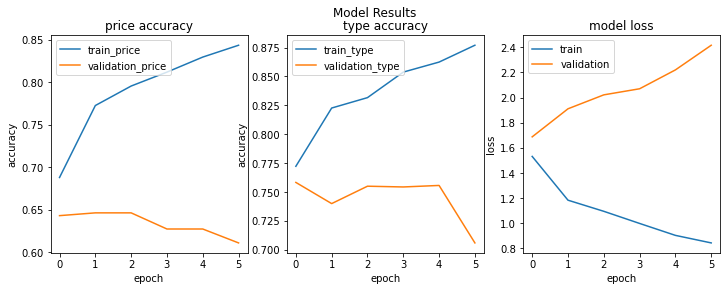

In [34]:
results_viz(history)

### test accuracy is decreased to 0.61983, and still i see overfitting
### As i show ,when i use two bidirectional layer is caused increasing in test accuracy
### with two ,test acc=0.95
### with one , test acc=91

# **Trial 6**
add two convolutional layers with two max pooling layers and two dropout layers 
and i add L2-regularization with dropout to prevent overfitting , and i add learning rate=0.001

In [12]:
from tensorflow.python.keras import regularizers
out=Bidirectional(LSTM(256))(embedded)
# image
conv=Conv2D(32,(12,12))(input_image)
pool=MaxPool2D(2,2)(conv) #stride =2
drop=Dropout(0.3)(pool)
conv2=Conv2D(64,(12,12))(pool)
pool=MaxPool2D(2,2)(conv2)
drop=Dropout(0.3)(pool)
flatten=Flatten()(drop)
#compine two parts for multi-modality
fused=tf.concat([out, flatten], axis=-1)
#for multi-task 
#build one dense layer for each
p_type = Dense(len_type, activation='softmax', name='type',kernel_regularizer=regularizers.l2(0.01))(fused)
p_price = Dense(len_price, activation='softmax', name='price',kernel_regularizer=regularizers.l2(0.01))(fused)
model=keras.Model(
    inputs={
        'summary': input_text,
        'image': input_image
    },
    outputs={
        'type': p_type,
        'price': p_price,
    },
)
#to compile model
model.compile(optimizer=Adam(learning_rate=0.001),
    loss={
        'type': 'sparse_categorical_crossentropy',
        'price': 'sparse_categorical_crossentropy',
    },
    metrics={
        'type': ['SparseCategoricalAccuracy'],
        'price': ['SparseCategoricalAccuracy'],
    },
)


model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 53, 53, 32)   9248        ['input_2[0][0]']                
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 26, 26, 32)  0           ['conv2d_1[0][0]']               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 15, 15, 64)   294976      ['max_pooling2d_1[0][0]']        
                                                                                            

In [12]:
history = model.fit(
    x={
        'summary': x_train_text_id,
        'image': x_train_image
    },
    y={
        'type': y_train_type,
        'price': y_train_price,
    },
    epochs=20,
    batch_size=16,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_price_loss', patience=5, )
    ],
    verbose=1
)

Epoch 1/20
382/382 [==============================] - 180s 466ms/step - loss: 1.9422 - price_loss: 0.8172 - type_loss: 1.0300 - price_sparse_categorical_accuracy: 0.6245 - type_sparse_categorical_accuracy: 0.7473 - val_loss: 1.6817 - val_price_loss: 0.7432 - val_type_loss: 0.9008 - val_price_sparse_categorical_accuracy: 0.6704 - val_type_sparse_categorical_accuracy: 0.7654
Epoch 2/20
382/382 [==============================] - 170s 446ms/step - loss: 1.6025 - price_loss: 0.7095 - type_loss: 0.8567 - price_sparse_categorical_accuracy: 0.6835 - type_sparse_categorical_accuracy: 0.7673 - val_loss: 1.6400 - val_price_loss: 0.7630 - val_type_loss: 0.8421 - val_price_sparse_categorical_accuracy: 0.6494 - val_type_sparse_categorical_accuracy: 0.7739
Epoch 3/20
382/382 [==============================] - 172s 450ms/step - loss: 1.4376 - price_loss: 0.6418 - type_loss: 0.7563 - price_sparse_categorical_accuracy: 0.7196 - type_sparse_categorical_accuracy: 0.7853 - val_loss: 1.6415 - val_price_loss

In [13]:
y_predict = model.predict(
    {
        'summary': x_test_text,
        'image': x_test_image
    }
)
# probabilities
price_predicted = y_predict['price']
type_predicted=y_predict['type']
print(price_predicted)
# categories
price_category_predicted = np.argmax(price_predicted, axis=1)
type_category_predicted = np.argmax(type_predicted, axis=1)
d=pd.DataFrame(
    {'id': data_test.id,
     'price': price_category_predicted}
).to_csv('sample_submissionbid4.csv', index=False)

[[1.3931887e-01 6.8181658e-01 1.7886458e-01]
 [9.9103594e-01 8.1890235e-03 7.7505718e-04]
 [9.7776788e-01 1.9328211e-02 2.9039332e-03]
 ...
 [5.4971367e-01 4.0976578e-01 4.0520530e-02]
 [9.8776615e-01 1.0587047e-02 1.6467753e-03]
 [2.6681417e-01 6.5743518e-01 7.5750701e-02]]


### test accuracy is increased to  0.64483

# Trial 7 with 3 conv layers one bidirectional 
with 3 dropout =0.5

In [13]:
#add one bidirectional layer
out=Bidirectional(LSTM(256))(embedded)
# for image part
# add the first conv layer
conv=Conv2D(32,(12,12))(input_image)
pool=MaxPool2D(2,2)(conv)
drop=Dropout(0.5)(pool)
#add the second conv layer
conv2=Conv2D(64,(12,12))(pool)
pool=MaxPool2D(1,1)(conv2)
drop=Dropout(0.5)(pool)
#add the third conv layer
conv3=Conv2D(128,(12,12))(pool)
pool=MaxPool2D(1,1)(conv3)
drop=Dropout(0.5)(pool)
flatten=Flatten()(drop)
#compine two parts for multi-modality
fused=tf.concat([out, flatten], axis=-1)
#for multi-task 
#build one dense layer for each
p_type = Dense(len_type, activation='softmax', name='type',kernel_regularizer=regularizers.l2(0.01))(fused)
p_price = Dense(len_price, activation='softmax', name='price',kernel_regularizer=regularizers.l2(0.01))(fused)
model=keras.Model(
    inputs={
        'summary': input_text,
        'image': input_image
    },
    outputs={
        'type': p_type,
        'price': p_price,
    },
)
model.compile(optimizer=Adam(learning_rate=0.001),
    loss={
        'type': 'sparse_categorical_crossentropy',
        'price': 'sparse_categorical_crossentropy',
    },
    metrics={
        'type': ['SparseCategoricalAccuracy'],
        'price': ['SparseCategoricalAccuracy'],
    },
)


model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 53, 53, 32)   9248        ['input_2[0][0]']                
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 26, 26, 32)  0           ['conv2d_3[0][0]']               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 15, 15, 64)   294976      ['max_pooling2d_3[0][0]']        
                                                                                            

In [14]:
history = model.fit(
    x={
        'summary': x_train_text_id,
        'image': x_train_image
    },
    y={
        'type': y_train_type,
        'price': y_train_price,
    },
    epochs=20,
    batch_size=16,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_price_loss', patience=5, )
    ],
    verbose=1
)

Epoch 1/20
367/367 [==============================] - 587s 2s/step - loss: 1.9939 - price_loss: 0.8231 - type_loss: 1.0077 - price_sparse_categorical_accuracy: 0.6241 - type_sparse_categorical_accuracy: 0.7531 - val_loss: 1.6483 - val_price_loss: 0.7212 - val_type_loss: 0.8445 - val_price_sparse_categorical_accuracy: 0.6753 - val_type_sparse_categorical_accuracy: 0.7790
Epoch 2/20
367/367 [==============================] - 526s 1s/step - loss: 1.6131 - price_loss: 0.7173 - type_loss: 0.8214 - price_sparse_categorical_accuracy: 0.6887 - type_sparse_categorical_accuracy: 0.7739 - val_loss: 1.6704 - val_price_loss: 0.7752 - val_type_loss: 0.8164 - val_price_sparse_categorical_accuracy: 0.6637 - val_type_sparse_categorical_accuracy: 0.7844
Epoch 3/20
367/367 [==============================] - 535s 1s/step - loss: 1.4586 - price_loss: 0.6545 - type_loss: 0.7278 - price_sparse_categorical_accuracy: 0.7220 - type_sparse_categorical_accuracy: 0.7969 - val_loss: 1.6314 - val_price_loss: 0.7364 

In [15]:
y_predict = model.predict(
    {
        'summary': x_test_text,
        'image': x_test_image
    }
)


# probabilities
price_predicted = y_predict['price']
type_predicted=y_predict['type']
print(price_predicted)

# categories
price_category_predicted = np.argmax(price_predicted, axis=1)
type_category_predicted = np.argmax(type_predicted, axis=1)
d=pd.DataFrame(
    {'id': data_test.id,
     'price': price_category_predicted}
).to_csv('sample_submissionbid5.csv', index=False)

230/230 [==============================] - 150s 642ms/step
[[7.3515713e-02 5.2560812e-01 4.0087616e-01]
 [9.9651128e-01 2.9513899e-03 5.3735677e-04]
 [9.9258292e-01 6.2222094e-03 1.1948555e-03]
 ...
 [7.5640547e-01 1.9185026e-01 5.1744174e-02]
 [9.9359363e-01 4.8837084e-03 1.5226532e-03]
 [3.1887409e-01 5.2921271e-01 1.5191314e-01]]


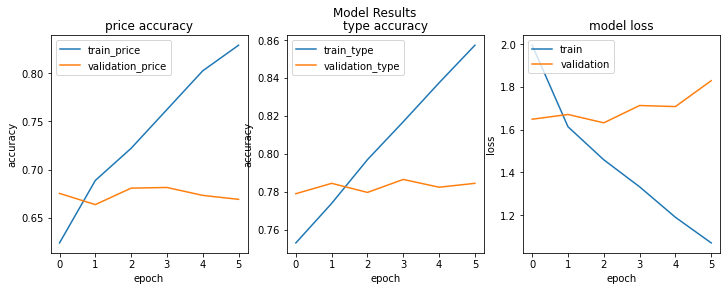

In [16]:
results_viz(history)

In [ ]:
### by adding 3 conv the test accuracy = 0.65407 is increased more than two conv 

# **Trial 8 with 3 conv layers and two LSTM**
accuracy is decreased and i will try to improve it by using two LSTM

In [17]:
out=SpatialDropout1D(0.2)(embedded)
out=LSTM(150,dropout=0.2,return_sequences=True)(out)
out1=LSTM(150)(out)
# image part 
# simple conv2d. you can change it to anything else as needed
conv=Conv2D(32,(12,12))(input_image)
pool=MaxPool2D(2,2)(conv)
drop=Dropout(0.25)(pool)
conv2=Conv2D(64,(12,12))(pool)
pool=MaxPool2D(1,1)(conv2)
drop=Dropout(0.25)(pool)
conv3=Conv2D(128,(12,12))(pool)
pool=MaxPool2D(1,1)(conv3)
drop=Dropout(0.2)(pool)
flatten=Flatten()(drop)
#compine two parts for multi-modality
fused=tf.concat([out1, flatten], axis=-1)
#for multi-task 
#build one dense layer for each
p_type = Dense(len_type, activation='softmax', name='type')(fused)
p_price = Dense(len_price, activation='softmax', name='price')(fused)
model=keras.Model(
    inputs={
        'summary': input_text,
        'image': input_image
    },
    outputs={
        'type': p_type,
        'price': p_price,
    },
)
model.compile(optimizer=Adam(),
    loss={
        'type': 'sparse_categorical_crossentropy',
        'price': 'sparse_categorical_crossentropy',
    },
    metrics={
        'type': ['SparseCategoricalAccuracy'],
        'price': ['SparseCategoricalAccuracy'],
    },
)


model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 53, 53, 32)   9248        ['input_2[0][0]']                
                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 26, 26, 32)  0           ['conv2d_6[0][0]']               
                                                                                                  
 conv2d_7 (Conv2D)              (None, 15, 15, 64)   294976      ['max_pooling2d_6[0][0]']        
                                                                                            

In [18]:
history = model.fit(
    x={
        'summary': x_train_text_id,
        'image': x_train_image
    },
    y={
        'type': y_train_type,
        'price': y_train_price,
    },
    epochs=20,
    batch_size=16,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_price_loss', patience=5, )
    ],
    verbose=1
)

Epoch 1/20
367/367 [==============================] - 352s 930ms/step - loss: 1.9286 - price_loss: 0.8590 - type_loss: 1.0696 - price_sparse_categorical_accuracy: 0.6102 - type_sparse_categorical_accuracy: 0.7529 - val_loss: 1.8209 - val_price_loss: 0.8547 - val_type_loss: 0.9662 - val_price_sparse_categorical_accuracy: 0.6241 - val_type_sparse_categorical_accuracy: 0.7688
Epoch 2/20
367/367 [==============================] - 337s 919ms/step - loss: 1.8683 - price_loss: 0.8467 - type_loss: 1.0215 - price_sparse_categorical_accuracy: 0.6196 - type_sparse_categorical_accuracy: 0.7560 - val_loss: 1.8278 - val_price_loss: 0.8363 - val_type_loss: 0.9915 - val_price_sparse_categorical_accuracy: 0.6241 - val_type_sparse_categorical_accuracy: 0.7688
Epoch 3/20
367/367 [==============================] - 350s 955ms/step - loss: 1.9775 - price_loss: 0.8812 - type_loss: 1.0962 - price_sparse_categorical_accuracy: 0.6002 - type_sparse_categorical_accuracy: 0.7469 - val_loss: 1.8029 - val_price_loss

In [19]:
y_predict=model.predict({
    'summary':x_test_text
    ,'image':x_test_image
})
predict=y_predict['price']
type_predicted=y_predict['type']
print(price_predicted)

# categories
type_category_predicted = np.argmax(type_predicted, axis=1)
price_category_predicted =np.argmax(predict, axis=1)
print(price_category_predicted)
d=pd.DataFrame(
    {'id': data_test.id,
     'price': price_category_predicted}
).to_csv('sample_submissionbid6.csv', index=False)

230/230 [==============================] - 92s 391ms/step
[[7.3515713e-02 5.2560812e-01 4.0087616e-01]
 [9.9651128e-01 2.9513899e-03 5.3735677e-04]
 [9.9258292e-01 6.2222094e-03 1.1948555e-03]
 ...
 [7.5640547e-01 1.9185026e-01 5.1744174e-02]
 [9.9359363e-01 4.8837084e-03 1.5226532e-03]
 [3.1887409e-01 5.2921271e-01 1.5191314e-01]]
[0 0 0 ... 0 0 0]


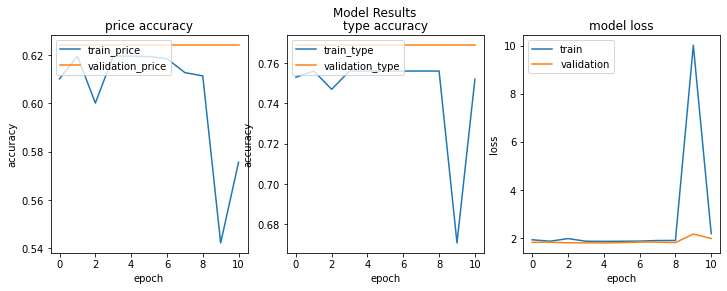

In [20]:
results_viz(history)

### test accuracy = 0.62038,i will try using two LSTM

# **Trial 9 with 3 conv layers and one LSTM**

In [22]:
out=SpatialDropout1D(0.2)(embedded)
out=LSTM(256,dropout=0.2)(out)
# image part 
# simple conv2d. you can change it to anything else as needed
conv=Conv2D(32,(12,12))(input_image)
pool=MaxPool2D(2,2)(conv)
drop=Dropout(0.25)(pool)
conv2=Conv2D(64,(12,12))(pool)
pool=MaxPool2D(1,1)(conv2)
drop=Dropout(0.25)(pool)
conv3=Conv2D(128,(12,12))(pool)
pool=MaxPool2D(1,1)(conv3)
drop=Dropout(0.2)(pool)
flatten=Flatten()(drop)
#compine two parts for multi-modality
fused=tf.concat([out, flatten], axis=-1)
#for multi-task 
#build one dense layer for each
p_type = Dense(len_type, activation='softmax', name='type')(fused)
p_price = Dense(len_price, activation='softmax', name='price')(fused)
model=keras.Model(
    inputs={
        'summary': input_text,
        'image': input_image
    },
    outputs={
        'type': p_type,
        'price': p_price,
    },
)
model.compile(optimizer=Adam(),
    loss={
        'type': 'sparse_categorical_crossentropy',
        'price': 'sparse_categorical_crossentropy',
    },
    metrics={
        'type': ['SparseCategoricalAccuracy'],
        'price': ['SparseCategoricalAccuracy'],
    },
)


model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 conv2d_9 (Conv2D)              (None, 53, 53, 32)   9248        ['input_2[0][0]']                
                                                                                                  
 max_pooling2d_9 (MaxPooling2D)  (None, 26, 26, 32)  0           ['conv2d_9[0][0]']               
                                                                                                  
 conv2d_10 (Conv2D)             (None, 15, 15, 64)   294976      ['max_pooling2d_9[0][0]']        
                                                                                            

In [23]:
history = model.fit(
    x={
        'summary': x_train_text_id,
        'image': x_train_image
    },
    y={
        'type': y_train_type,
        'price': y_train_price,
    },
    epochs=20,
    batch_size=16,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_price_loss', patience=5, )
    ],
    verbose=1
)

Epoch 1/20
367/367 [==============================] - 352s 946ms/step - loss: 1.9219 - price_loss: 0.8562 - type_loss: 1.0657 - price_sparse_categorical_accuracy: 0.6137 - type_sparse_categorical_accuracy: 0.7536 - val_loss: 1.7976 - val_price_loss: 0.8299 - val_type_loss: 0.9677 - val_price_sparse_categorical_accuracy: 0.6241 - val_type_sparse_categorical_accuracy: 0.7688
Epoch 2/20
367/367 [==============================] - 352s 958ms/step - loss: 1.8961 - price_loss: 0.8541 - type_loss: 1.0421 - price_sparse_categorical_accuracy: 0.6152 - type_sparse_categorical_accuracy: 0.7560 - val_loss: 2.0074 - val_price_loss: 0.8807 - val_type_loss: 1.1266 - val_price_sparse_categorical_accuracy: 0.6241 - val_type_sparse_categorical_accuracy: 0.7688
Epoch 3/20
367/367 [==============================] - 361s 983ms/step - loss: 1.8870 - price_loss: 0.8514 - type_loss: 1.0356 - price_sparse_categorical_accuracy: 0.6080 - type_sparse_categorical_accuracy: 0.7560 - val_loss: 1.8180 - val_price_loss

In [24]:
y_predict=model.predict({
    'summary':x_test_text
    ,'image':x_test_image
})
predict=y_predict['price']
type_predicted=y_predict['type']
print(price_predicted)

# categories
type_category_predicted = np.argmax(type_predicted, axis=1)
price_category_predicted =np.argmax(predict, axis=1)
print(price_category_predicted)
d=pd.DataFrame(
    {'id': data_test.id,
     'price': price_category_predicted}
).to_csv('sample_submissionbid9.csv', index=False)

230/230 [==============================] - 86s 373ms/step
[[7.3515713e-02 5.2560812e-01 4.0087616e-01]
 [9.9651128e-01 2.9513899e-03 5.3735677e-04]
 [9.9258292e-01 6.2222094e-03 1.1948555e-03]
 ...
 [7.5640547e-01 1.9185026e-01 5.1744174e-02]
 [9.9359363e-01 4.8837084e-03 1.5226532e-03]
 [3.1887409e-01 5.2921271e-01 1.5191314e-01]]
[0 0 0 ... 0 0 0]


### test accuracy still the same =0.62038

## Is fully-connected model a good one for sequential data? Why? How about for image data? Is it good? Why?
-Isn't good for sequential data,because it cannot capture sequential information in the input data which is required for dealing with sequence data and memory dependence
Considers only the current input
Cannot memorize previous inputs but RNN is good for sequential data                                      
-Isn't good for image , because fully connected networks are structure agnostic. there are no special assumptions needed to be made about the input.
While being structure agnostic makes fully connected networks very broadly applicable, such networks do tend to have weaker performance than special-purpose networks tuned to the structure of a problem space.
Although fully connected networks make no assumptions about the input they tend to perform less and aren’t good for feature extraction. Plus they have a higher number of weights to train that results in high training time but CNN is good

## What is gradient vanishing and gradient explosion, and how GRU/LSTM tries to mitigate this problem?
1- gradient vanishing when the gradients carry information used in the RNN, and when the gradient becomes too small, the parameter updates become insignificant. This makes the learning of long data sequences difficult.                       
2-gradient explosion ,this problem arises when large error gradients accumulate, resulting in very large updates to the neural network model weights during the training process.                                
-LSTM network has three gates that update and control the cell states, these are the forget gate, input gate and output gate. The gates use hyperbolic tangent and sigmoid activation functions.                                 
1-The forget gate controls what information in the cell state to forget, given new information than entered the network.      
2-The input gate controls what new information will be encoded into the cell state, given the new input information and  update of the cell state                                                   
3-The output gate controls what information encoded in the cell state is sent to the network as input in the following time step                                            
-GRU’s capability of using gates and memory cells makes it an efficient solution for our vanishing gradient problem. This is because the gate of GRU can easily be set to 0.There are two gates forget and output .

## What is multi-objective/multi-task learning? What is multi-modality learning? How do you use them in this assignment?
-Multi-task learning learns multiple tasks simultaneously are solved at the same time, while exploiting commonalities and differences across tasks, optimizing multiple loss functions at once, multi-task learning should be used when the tasks have some level of correlation     
-Multimodal learning is teaching from more than one source . By engaging the mind in multiple learning styles at the same time, learners experience a diverse learning style that collectively suits all of them.                            
1-Multi-task in assignment combines ( type and price ) two outputs                          
2-multimodality combines the text model and image model

## What is the difference among xgboost, lightgbm and catboost?
-a trained CatBoost tree can predict extraordinarily faster than either XGBoost or LightGBM
1- LightGBM (LightGBM does support categories, but has more limitations than CatBoost)is unique in that it can construct trees using Gradient-Based One-Sided Sampling.GOSS allows LightGBM to quickly find the most influential split and affecting a loss function and updates an underfit tree according to a selection of the largest gradients and randomly sampled small gradients, it has Lower memory consumption, is faster than xgboost.                                         
2- Better handling of missing values ,Faster – optimized for multi-threading/processing.uses the gradients of different cuts to select the next cut, but XGBoost also uses the hessian, or second derivative, in its ranking of cuts. Computing this next derivative comes at a slight cost, but it also allows a greater estimation of the cut to use.                        
3-CatBoost determines different categories automatically with no need for preprocessing and is designed for categorical data and is known to have the best performance on it